In [1]:
import numpy as np
import pandas as pd

seed_no = 42
np.random.seed(seed_no)  # Fix the seed for reproducibility

# We can use Scikit-learn (sklearn) for preprocessing and training linear models for mean and quantile prediction
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,  QuantileRegressor

# helper functions for this notebook
from Predict_and_Optimize_for_Operating_Room_Management_util import DAP_Model, generate_instances, flatten_ignore_padding, plot, generate_synthetic_data

## Surgery duration data

As you can imagine, surgery data contains highly sensitive information, such as demographic data and health information about patients. Therefore, for this demo, we will generate our data synthetically. Nevertheless, the demo can also be run with real data in a similar way.


We generate our synthetic data, which is a list of to-be-planned **surgeries**, each with a feature vector (`X`) and a target variable (`y`).  Each feature vector represents information about a surgery (the type of the surgery, the number of surgeons working on the surgery etc.) or the information about the patient undergoing the surgery (such as the gender, age, etc.). The target variable is the duration of the surgery.

In [2]:
X_values, y_values = generate_synthetic_data(num_features=5, num_samples=1000)

Let's check how a feature vector looks like for the first surgery:

In [3]:
print(f"The feature vector of the first surgery:\n\t{X_values[0]}\n which encodes information about the surgery and the patient.")
print(f"The duration of the first surgery is:\n\t{y_values[0]:.2f} minutes")


The feature vector of the first surgery:
	[0.15599452 0.05808361 0.86617615 0.60111501 0.70807258]
 which encodes information about the surgery and the patient.
The duration of the first surgery is:
	90.73 minutes


## Training a surgery time predictor on training data

Now as a common practice in machine learning, we split the surgery data into training, validation, and test sets. We also standardize the features to have zero mean and unit variance.

In [4]:
X_train, X_temp, y_train, y_temp = train_test_split(X_values, y_values, test_size=0.4, random_state=seed_no)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed_no)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

### Daily surgical case Assignment Problem

Our goal will be to plan the surgeries for the next day, by solving the Daily surgical case Assignment Problem (DAP) with the estimated durations.

This means that we will have observed, and will need to predict, a *set* of surgeries corresponding to one day or shift. Therefore, to simulate this, we generate instances of the DAP by sampling from the surgeries. Each DAP instance has a number of surgeries (between `min_patients` and `max_patients`) and the corresponding features and target variable. (technically, we pad the patients upto max_patients, these padding is ignored when solving the DAP later)

In [5]:
num_train_instances = 200
num_validation_instances = 50
num_test_instances = 50

min_patients = 4
max_patients = 8

X_train_instances, y_train_instances = generate_instances(X_train, y_train, num_train_instances, min_patients, max_patients)
X_validation_instances, y_validation_instances = generate_instances(X_validation, y_validation, num_validation_instances, min_patients, max_patients)
X_test_instances, y_test_instances = generate_instances(X_test, y_test, num_test_instances, min_patients, max_patients)

Let's look at the surgeries that make up the first training DAP:

In [6]:
for i, row in enumerate(X_train_instances[0]):
    if np.allclose(row, 0):
        continue
    print(f"Surgery feature {i+1}: [{', '.join(f'{v:.2f}' for v in row)}]")

Surgery feature 1: [-0.12, 0.52, 0.91, 0.90, 0.28]
Surgery feature 2: [-1.65, -1.50, -0.09, 1.42, 0.14]
Surgery feature 3: [0.22, 0.86, 1.35, -0.50, 1.14]
Surgery feature 4: [-1.51, 1.24, -0.34, 0.18, 1.65]
Surgery feature 5: [-1.72, -0.36, -0.88, 1.12, -0.56]
Surgery feature 6: [0.36, -0.74, 0.32, -1.13, -0.06]


and the corresponding target values (true durations of the surgeries):

In [7]:
for i, row in enumerate(y_train_instances[0]):
    if np.allclose(row, 0):
        continue
    print(f"Surgery true duration {i+1}: {', '.join(f'{v:.2f}' for v in row)}")

Surgery true duration 1: 225.64
Surgery true duration 2: 107.47
Surgery true duration 3: 212.08
Surgery true duration 4: 218.68
Surgery true duration 5: 211.73
Surgery true duration 6: 196.59


### Training

We can first train a linear regression model to predict the mean duration of the surgeries.

In [8]:
# Flatten train and validation sets, ignoring padded (zero) rows
X_train_flat, y_train_flat = flatten_ignore_padding(X_train_instances, y_train_instances)

# Train linear regression
linear_reg = LinearRegression()
linear_reg.fit(X_train_flat, y_train_flat)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


From a DAP decision making perspective, the expected (mean) duration may not the best approach, as it does not account for the asymmetry of under-prediction (potential under-use of an operating rooms) and over-prediction (potential overtime for all the staff).

Instead, we can use **quantile regression** to predict a specific quantile of the surgery duration distribution. For example, a quantile level of 0.5 corresponds to the median prediction, while a quantile level of 0.8 estimates a value such that approximately 80% of surgeries are expected to take less time and 20% take longer.

In [9]:
quantile_levels = [0.5, 0.6, 0.7, 0.8, 0.9]  # [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

quantile_reg = {}
for q in quantile_levels:
    qr = QuantileRegressor(quantile=q, alpha=0)
    qr.fit(X_train_flat, y_train_flat.ravel())
    quantile_reg[q] = qr

We can visualize the predictions for some surgeries in the training set to see how the mean and quantile predictions differ.

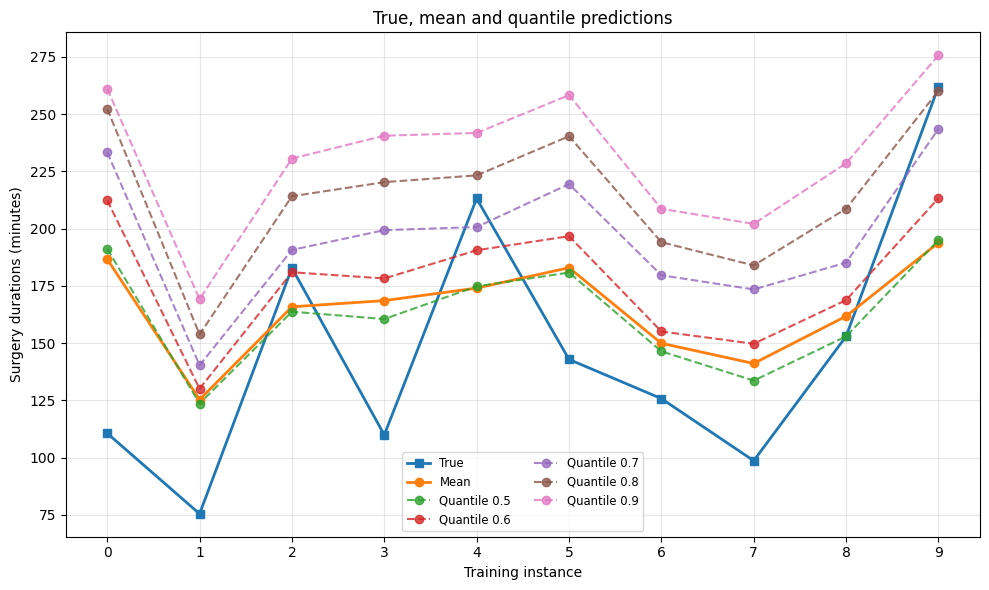

In [10]:
import matplotlib.pyplot as plt

xs = np.arange(10)

true_values = []
mean_values = []
quantile_values = {q: [] for q in quantile_levels}

for i in xs:
    features = X_train[i].reshape(1, -1)
    true_duration = y_train[i]
    true_values.append(true_duration)

    mean_pred = linear_reg.predict(features).ravel()[0]
    mean_values.append(mean_pred)

    for q in quantile_levels:
        q_pred = quantile_reg[q].predict(features).ravel()[0]
        quantile_values[q].append(q_pred)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(xs, true_values, marker='s', linestyle='-', label='True', linewidth=2)
plt.plot(xs, mean_values, marker='o', linestyle='-', label='Mean', linewidth=2)

for q in quantile_levels:
    plt.plot(xs, quantile_values[q], marker='o', linestyle='--', alpha=0.8, label=f'Quantile {q}')

plt.xlabel('Training instance')
plt.ylabel('Surgery durations (minutes)')
plt.title('True, mean and quantile predictions')
plt.xticks(xs)
plt.grid(alpha=0.3)
plt.legend(ncol=2, fontsize='small')
plt.tight_layout()
plt.show()

The predictions are not very accurate since the true relationship between the features and the durations is non-linear, while the models we are using are linear. While the model misspecification here is artificial, actual model misspecification even when using non-linear models is highly common in many real-world applications, where the true underlying relationships are often more complex than the assumptions made by the chosen models.

Let's consider a specific DAP instance to understand how the different predictions lead to different decisions in the DAP model. Normally, we don't know the true durations. But if we would, we could come up with the optimal assignment of surgeries to ORs.

In [11]:
idx = 10
features = X_test_instances[idx]
true_durations = y_test_instances[idx]
mask = ~(y_test_instances[idx].flatten() == 0) # mask to ignore padded rows

### Ground truth solution

We can define and solve DAP with the CPMpy constraint solving library. The assignment can then be visualized as a Gantt chart, where each row represents an Operating Room (OR) and the bars represent the surgeries assigned to that OR.

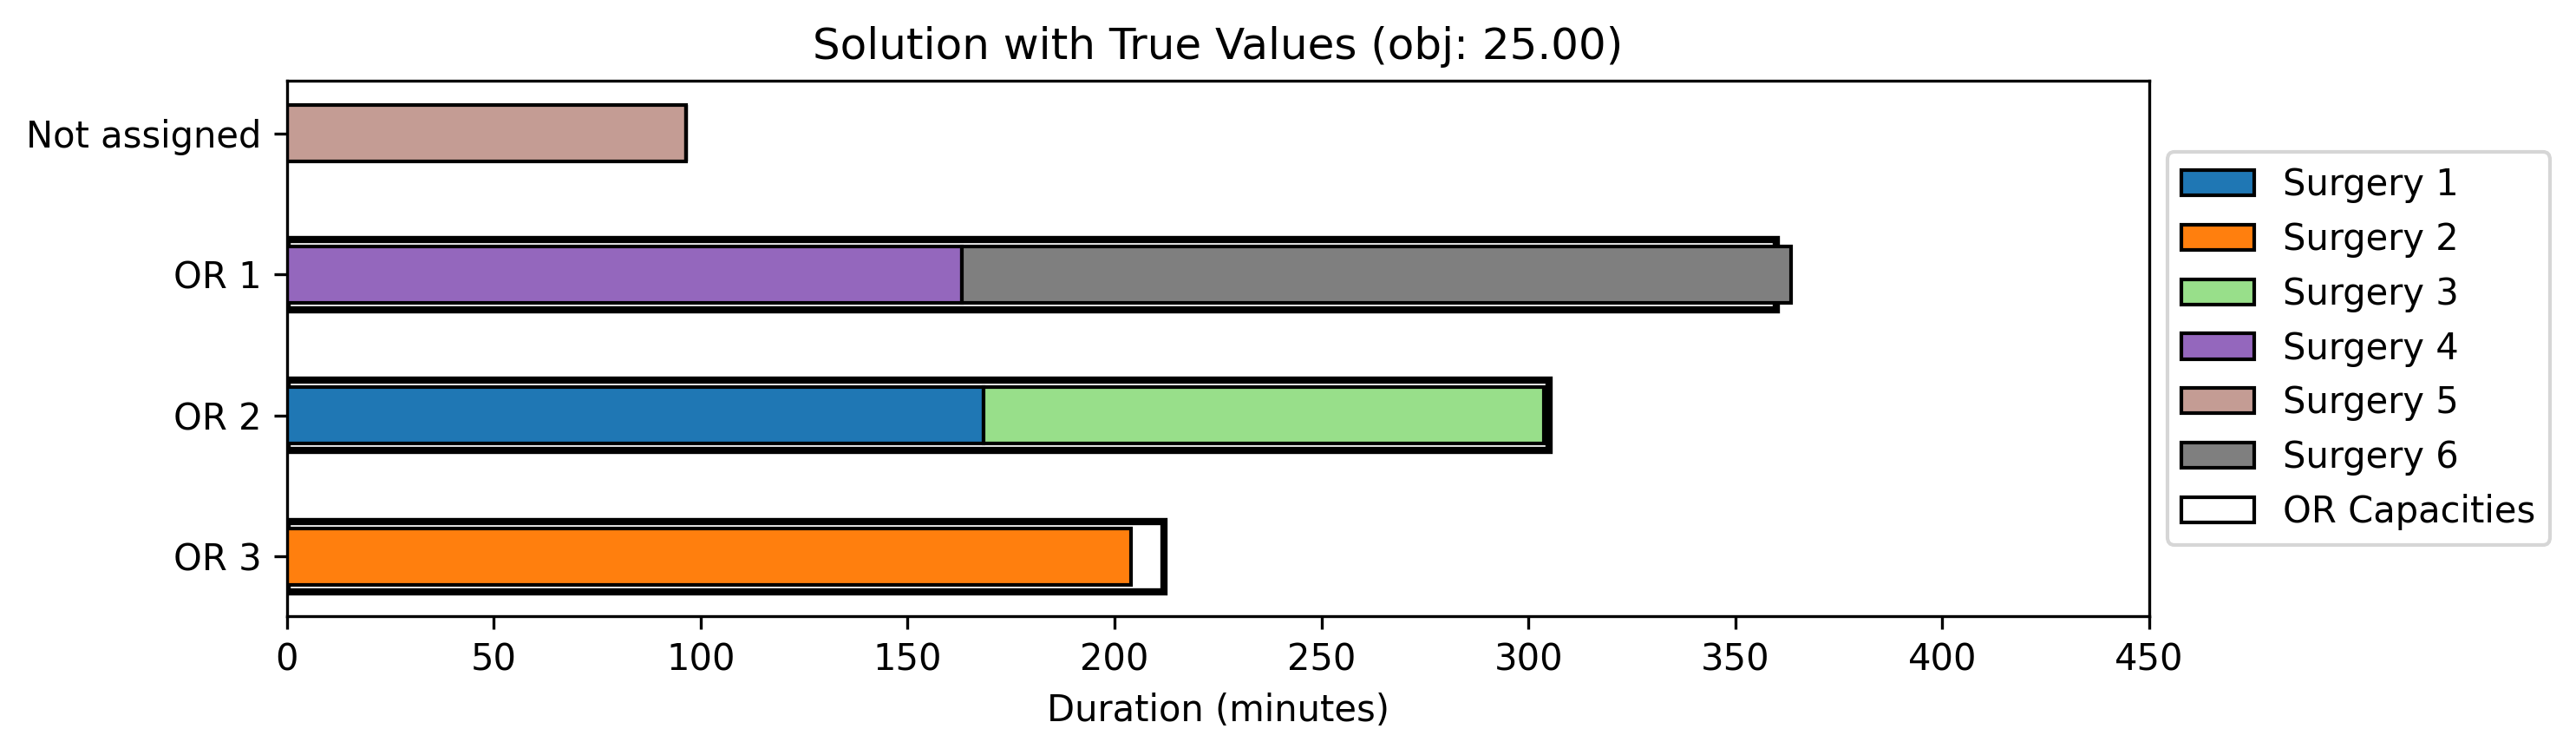

In [12]:
underuse = 1 # underuse unit cost
overuse = 5 # overuse unit cost
capacities = [360, 305, 212] # capacities of three ORs in minutes
model = DAP_Model(max_patients, capacities, underuse, overuse)

true_obj, true_sol  = model.solve(true_durations)
plot(true_sol['x'], f"Solution with True Values (obj: {true_obj:.2f})", max_patients, true_durations, capacities)

In the optimal solution with true durations, we usually see that some ORs are underused while others are overused. Also. some surgeries are not assigned to any OR, which means they are postponed to another day.

### Mean duration, resulting solution

When we don't know the true durations, we can use predictions for the mean duration of the surgeries and solve the model.

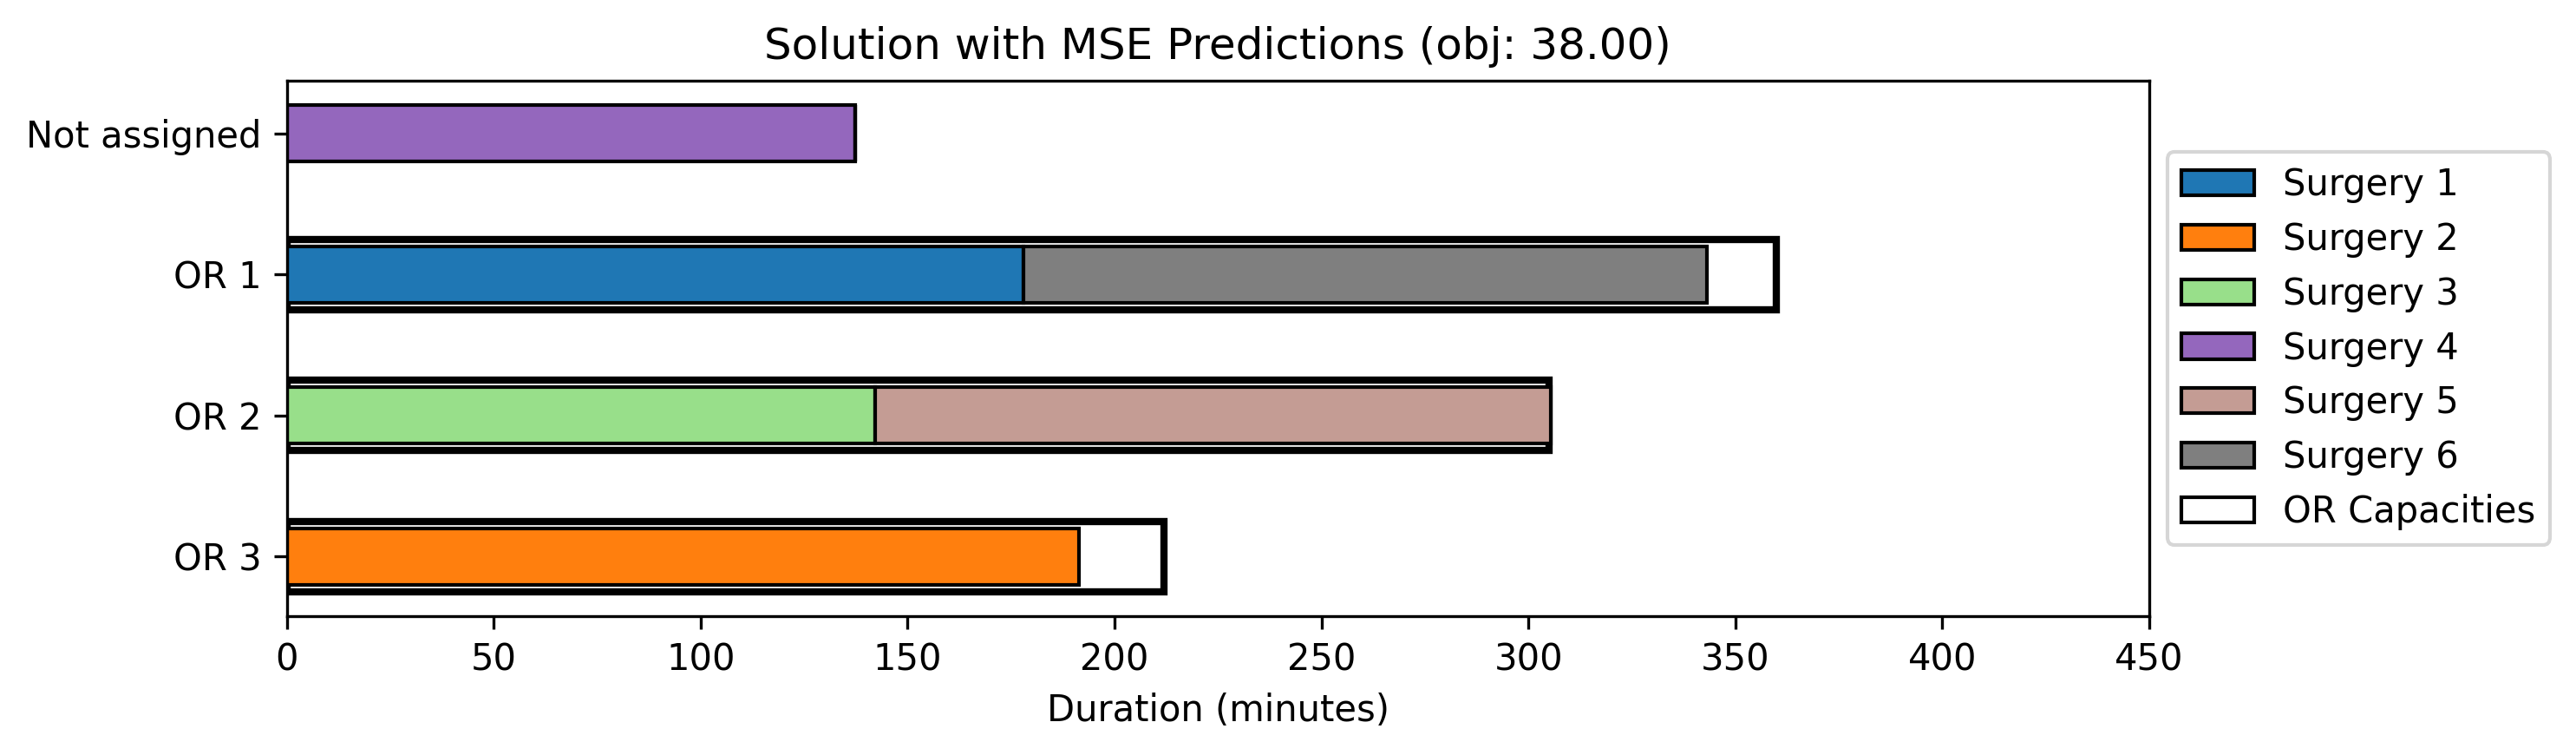

In [13]:
regret_data = []

mean_durations = linear_reg.predict(features)
mean_durations[~mask] = 0

m_obj, m_sol = model.solve(mean_durations)
plot(m_sol['x'], f"Solution with MSE Predictions (obj: {m_obj:.2f})", max_patients, mean_durations, capacities)

The schedule looks decent, however, this is with the expected surgery durations. Let's look at what will really happen, when we use the true durations.

### Mean duration, resulting solution with actual durations


Objective of MSE solution, with the real durations: 124.24
Objective of True solution, with the real durations: 25.00
Regret (difference between the two): 99.24


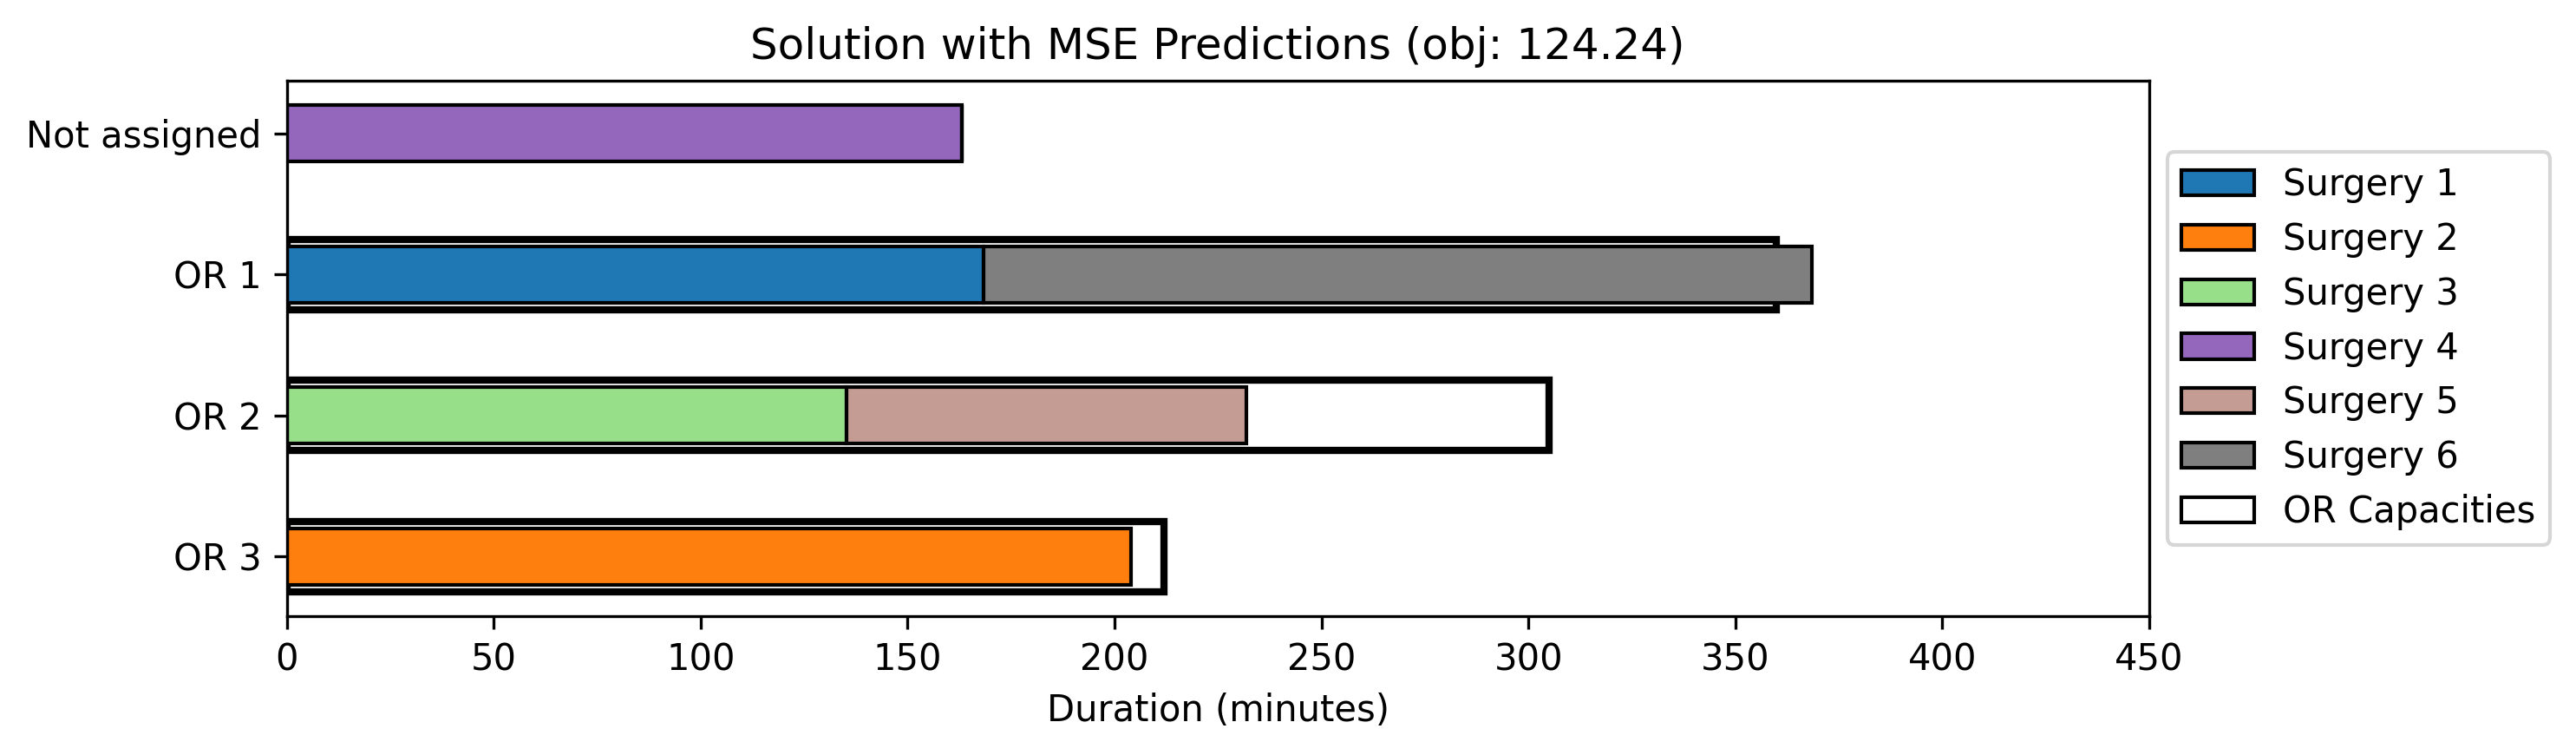

In [14]:
m_actual_obj = model.get_objective_value(true_durations, m_sol['x'])
print(f"Objective of MSE solution, with the real durations: {m_actual_obj:.2f}")
print(f"Objective of True solution, with the real durations: {true_obj:.2f}")
print(f"Regret (difference between the two): {m_actual_obj - true_obj:.2f}")

regret_data.append({
    "prediction": "Mean",
    "regret": m_actual_obj - true_obj
})

plot(m_sol['x'], f"Solution with MSE Predictions (obj: {m_actual_obj:.2f})", max_patients, true_durations, capacities)

The decisions with the mean prediction model are have errors, and this leads to a mismatch under the true durations (that will be reveiled as we execute the plan).

### Quantile prediction duration and solution quality

We can also use the quantile regression models to predict the quantiles of the durations and solve the model for each quantile. This way we can get a range of solutions and see how the decision quality, the regret, changes with different quantiles.

In [15]:
for q in quantile_levels:
    q_predictions = quantile_reg[q].predict(features)
    q_predictions[~mask] = 0
    q_obj, q_sol = model.solve(q_predictions)
    q_actual_obj = model.get_objective_value(true_durations, q_sol['x'])
    print(f"Quantile {q}: Objective with Decisions: {q_actual_obj:.2f}, "
          f"\n\tRegret {q_actual_obj-true_obj:.2f}")

    #Uncomment to visualize the solutions for different quantiles
    #plot(q_sol['x'], f"Quantile {q} Solution", max_patients, true_durations, capacities)

    regret_data.append({
        "prediction": f"Quantile {q}",
        "regret": q_actual_obj-true_obj
    })

Quantile 0.5: Objective with Decisions: 337.98, 
	Regret 312.98
Quantile 0.6: Objective with Decisions: 77.88, 
	Regret 52.88
Quantile 0.7: Objective with Decisions: 245.13, 
	Regret 220.13
Quantile 0.8: Objective with Decisions: 278.12, 
	Regret 253.12
Quantile 0.9: Objective with Decisions: 369.31, 
	Regret 344.31


Now we can check the regrets for different prediction methods. We can see that the mean prediction has a higher regret than some of the quantile predictions.

In [16]:
df_regrets = pd.DataFrame(regret_data).sort_values('regret').set_index('prediction')
from IPython.display import display
display(df_regrets)


,regret
prediction,
Quantile 0.6,52.876673
Mean,99.236543
Quantile 0.7,220.131164
Quantile 0.8,253.120515
Quantile 0.5,312.977938
Quantile 0.9,344.309425


## Decision-aware quantile selection

We can see that quantile level 0.6 works best for this instance. But when we observe a new instance, we wouldn't know which quantile level will work best. Therefore, we can evaluate the performance of different quantile levels on the validation set and select the best quantile level based on the average regret.

In [17]:
df_validation_regrets = []
for i in range(len(X_validation_instances)):
    features = X_validation_instances[i]
    true_durations = y_validation_instances[i]
    mask = ~(y_validation_instances[i].flatten() == 0)
    true_obj, true_sol  = model.solve(true_durations)
    mean_predictions = linear_reg.predict(features)
    mean_predictions[~mask] = 0
    m_obj, m_sol = model.solve(mean_predictions)
    obj_with_mean_decisions = model.get_objective_value(true_durations, m_sol['x'])
    df_validation_regrets.append({
        "instance": i,
        "quantile": "Mean",
        "regret": obj_with_mean_decisions - true_obj
    })


    for q in quantile_levels:
        q_predictions = quantile_reg[q].predict(features)
        q_predictions[~mask] = 0
        q_obj, q_sol = model.solve(q_predictions)
        q_obj_with_decisions = model.get_objective_value(true_durations, q_sol['x'])
        df_validation_regrets.append({
            "instance": i,
            "quantile": q,
            "regret": q_obj_with_decisions-true_obj
        })

# see which quantile level works best on average on the validation set
df_val = pd.DataFrame(df_validation_regrets)
summary = df_val.groupby('quantile')['regret'].agg(['mean', 'std', 'count']).reset_index()
summary_sorted = summary.sort_values('mean').set_index('quantile')
summary_sorted[['mean', 'std']] = summary_sorted[['mean', 'std']].round(2)
display(summary_sorted)

,mean,std,count
quantile,,,
0.6,166.15,161.39,50
Mean,175.91,199.80,50
0.7,184.43,121.98,50
0.5,201.07,214.10,50
0.8,226.61,126.53,50
0.9,264.68,121.65,50


It seems that quantile level 0.6 works best on average on the validation set. Now we can evaluate the performance of this quantile level on the test set and compare it with the mean prediction model.

### Final evaluation on testset: MSE vs decision-aware choice of quantile

In [18]:
best_quantile = summary_sorted.index[0]

df_test_regrets = []

for i in range(len(X_test_instances)):
    features = X_test_instances[i]
    true_durations = y_test_instances[i]
    mask = ~(y_test_instances[i].flatten() == 0)
    true_obj, true_sol = model.solve(true_durations)

    # Mean prediction
    mean_predictions = linear_reg.predict(features)
    mean_predictions[~mask] = 0
    m_obj, m_sol = model.solve(mean_predictions)
    obj_with_mean_decisions = model.get_objective_value(true_durations, m_sol['x'])
    df_test_regrets.append({
        "instance": i,
        "model": "Mean",
        "regret": obj_with_mean_decisions - true_obj
    })

    # Best quantile prediction
    q_predictions = quantile_reg[best_quantile].predict(features)
    q_predictions[~mask] = 0
    q_obj, q_sol = model.solve(q_predictions)
    q_obj_with_decisions = model.get_objective_value(true_durations, q_sol['x'])
    df_test_regrets.append({
        "instance": i,
        "model": f"Quantile {best_quantile}",
        "regret": q_obj_with_decisions - true_obj
    })

df_test = pd.DataFrame(df_test_regrets)
summary_test = df_test.groupby('model')['regret'].agg(['mean', 'std', 'count']).round(2)
summary_test_sorted = summary_test.sort_values('mean')
display(summary_test_sorted)

,mean,std,count
model,,,
Quantile 0.6,226.99,191.21,50
Mean,259.60,268.83,50


The quantile prediction model selected based on the validation set outperforms the mean prediction model on the test set in terms of average regret. This demonstrates the advantage of using quantile regression and doing a decision-awareq quantile selection for decision-making in the DAP model: as it better captures the uncertainty and asymmetry in the cost structure.

Since only the selection on the validation set requires calling the solver to compute solutions, it is also very fast and easy to deploy in practice.